
# PAST — Perceptron as Similarity Transformation

This notebook estimates a 3D similarity transformation between two coordinate frames using a **white‑box** single-layer perceptron trained by **gradient descent**, and includes LSM (SVD) baselines for comparison.

**The notebook provides four transformation variants:**
- **PAST_raw** — learned linear mapping (gradient-based)
- **PAST_SVD** — SVD projection of PAST_raw to the closest similarity transform
- **LSM** — classical SVD-based baseline (Kabsch: rigid *(R,t)*; Umeyama: similarity *(s,R,t)*)
- **HYB (LSM + PAST_raw residuals)** — LSM + learned residual correction

It supports two input modes:

1. **[GeoPOINT](https://github.com/Baltic-Coastal-Monitoring-Team/GeoPOINT) mode** — load a single workbook (`.xlsx`) and use **Original_Global** (fixed) and **Transformed_Local** (local) sheets.
2. **External mode** — load two user files (`.csv`/`.xlsx`) with paired points (Local and Fixed).

**Outputs:**
- train/validation metrics: **RMSE** per axis, **RMST (3D aggregate from axis-wise RMSE)**, and **NRMSE (range normalised)**
- parameters for **PAST_raw**, **PAST_SVD**, **LSM**, and **HYB**
- RMSE convergence plot
- axis-wise RMSE bar chart (σx, σy, σz)
- optional 3D scatter of predicted vs. reference points
- export to `results_past.csv` and `results_past.json`

> Notes: pre-scaling (`SCALE_MODE="pre"`) and activation functions (`ACTIVATION`) are configured in the **Parameters** section. Activation options are experimental; for similarity/rigid transformations the recommended default is `identity`.


## 1. Paths & Parameters

In [2]:
# --- USER CONFIGURATION ---
# Choose ONE of the following modes by setting the respective paths:
# (A) GeoPOINT mode: provide a single workbook path (xlsx) that contains sheets:
#     ['Original_Global', 'Transformed_Local', 'Angles_(rad)', 'Metadata']
GEOPOINT_WORKBOOK = "geopoint_data/synthetic_with_noise_coordinates.xlsx"  # e.g., "data/synthetic_with_noise_coordinates.xlsx"

# (B) External mode: provide two files (csv/xlsx) with identical points (same order & count)
#     Each must contain columns: X, Y, Z
EXTERNAL_LOCAL_PATH = ""  # e.g., "data/dataset_local.csv"
EXTERNAL_FIXED_PATH = ""  # e.g., "data/dataset_fixed.csv"

# Training/validation split: use the LAST n records as GCPs (training), others for validation
N_GCP = 5

# Optimization parameters
MAX_ITERS = 200_000
INIT_LR = 1e-4
TOL = 1e-8  # stop if RMSE change below this threshold

# Reproducibility
RANDOM_SEED = 42 # random seed used only for initialization of perceptron weights (not for data generation)

# Activation function for PAST (per-axis model)
# Options: "identity" (linear), "tanh", "sigmoid", "relu"
ACTIVATION = "identity"
# Hybrid residual model can use the same activation (or set independently)
RESIDUAL_ACTIVATION = ACTIVATION

# Scale handling (pre-scaling of X_local before training)
# Options: "none", "pre"
SCALE_MODE = "pre"
# Options: "pairwise" (LS on distances) or "centroid" (RMS radius ratio)
SCALE_ESTIMATOR = "centroid"

# Plotting
PLOT_3D = True  # set to False if 3D not desired

## 2. Imports & Utilities

In [3]:
import os
import math
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time 
import io 
import contextlib 
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import r2_score
from typing import Tuple 

# Try to import torch; if unavailable, use NumPy-only fallback
try:
    import torch
    TORCH_AVAILABLE = True
except Exception:
    TORCH_AVAILABLE = False

np.random.seed(RANDOM_SEED)
if TORCH_AVAILABLE:
    torch.manual_seed(RANDOM_SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(RANDOM_SEED)

def adaptive_lr(loss_value, base_lr):
    if loss_value < 1e-3:
        return 5e-8
    if loss_value < 1e-2:
        return 5e-7
    if loss_value < 1e-1:
        return 1e-6
    if loss_value < 1.0:
        return 5e-5
    return base_lr

def rmse(a, b):
    """Compute Root Mean Square Error (RMSE) between two 3D point sets."""
    return float(np.sqrt(np.mean((a - b) ** 2)))

def orthogonality_checks_improved(R,
                                  tol_fro=1e-6,
                                  tol_col=1e-6,
                                  tol_det=1e-6,
                                  return_R_proj=False):
    """
    Detailed orthogonality/proper-rotation check for a 3x3 matrix R.

    Returns a report dictionary with:
      - dots: pairwise dot-products of columns 
      - norms_sq: squared norms of columns 
      - detR: determinant of R
      - fro_error: Frobenius norm of (R^T R - I)
      - max_offdiag: max absolute off-diagonal in (R^T R - I)
      - col_norms: lengths of column vectors
      - col_norm_devs: absolute deviations of column lengths from 1
      - max_col_dev: maximum column length deviation
      - det_dev: absolute deviation of det(R) from +1
      - singular_values: singular values of R
      - proj_error: Frobenius norm ||R - R_proj|| where R_proj is nearest orthogonal matrix (det=+1)
      - R_proj: the nearest proper-rotation matrix (only if return_R_proj=True)
      - boolean flags: ok_fro, ok_cols, ok_det, is_orthonormal, is_proper_rotation
    """

    R = np.asarray(R, dtype=float)
    if R.shape != (3, 3):
        raise ValueError("R must be a 3x3 matrix")

    # columns
    c1, c2, c3 = R[:, 0], R[:, 1], R[:, 2]

    # Returns dot products, squared norms, and determinant of 
    dots = {
        "c1·c2": float(np.dot(c1, c2)),
        "c1·c3": float(np.dot(c1, c3)),
        "c2·c3": float(np.dot(c2, c3)),
    }
    norms_sq = {
        "||c1||^2": float(np.dot(c1, c1)),
        "||c2||^2": float(np.dot(c2, c2)),
        "||c3||^2": float(np.dot(c3, c3)),
    }

    # orthogonality error: R^T R - I
    RtR = R.T @ R
    I = np.eye(3)
    diff = RtR - I
    fro_error = float(np.linalg.norm(diff, ord='fro'))
    # maximum off-diagonal absolute entry (useful quick check)
    offdiag = diff - np.diag(np.diag(diff))
    max_offdiag = float(np.max(np.abs(offdiag)))

    # column norms and deviations
    col_norms = np.sqrt(np.array([norms_sq["||c1||^2"], norms_sq["||c2||^2"], norms_sq["||c3||^2"]], dtype=float))
    col_norm_devs = np.abs(col_norms - 1.0)
    max_col_dev = float(np.max(col_norm_devs))

    # determinant
    detR = float(np.linalg.det(R))
    det_dev = abs(detR - 1.0)

    # SVD based nearest orthogonal matrix (then enforce det=+1)
    U, S, Vt = np.linalg.svd(R)
    R_proj = U @ Vt
    if np.linalg.det(R_proj) < 0:
        # flip last column of U to make det positive (Kabsch trick)
        U[:, -1] *= -1
        R_proj = U @ Vt
    proj_error = float(np.linalg.norm(R - R_proj, ord='fro'))

    singular_values = S.astype(float)

    # Boolean checks
    ok_fro = fro_error <= tol_fro
    ok_cols = max_col_dev <= tol_col
    ok_det = det_dev <= tol_det
    is_orthonormal = ok_fro and ok_cols
    is_proper_rotation = ok_det and (detR > 0)

    report = {
        "dots": dots,
        "norms_sq": norms_sq,
        "detR": detR,
        "fro_error": fro_error,
        "max_offdiag": max_offdiag,
        "col_norms": col_norms.tolist(),
        "col_norm_devs": col_norm_devs.tolist(),
        "max_col_dev": max_col_dev,
        "det_dev": det_dev,
        "singular_values": singular_values.tolist(),
        "proj_error": proj_error,
        "ok_fro": bool(ok_fro),
        "ok_cols": bool(ok_cols),
        "ok_det": bool(ok_det),
        "is_orthonormal": bool(is_orthonormal),
        "is_proper_rotation": bool(is_proper_rotation),
    }

    if return_R_proj:
        report["R_proj"] = R_proj

    return report

def orthogonality_checks(R):
    """
    Backwards-compatible wrapper: returns (dots, norms, detR).
    Use orthogonality_checks_improved for full report.
    """
    rep = orthogonality_checks_improved(R)
    return rep["dots"], rep["norms_sq"], rep["detR"]

def print_orthogonality_report(rep_or_R, show_Rproj=False):
    """
    Print orthogonality report with key mathematical metrics.
    """
    # Handle both dict and matrix input
    if isinstance(rep_or_R, np.ndarray) and rep_or_R.shape == (3, 3):
        rep = orthogonality_checks_improved(rep_or_R, return_R_proj=show_Rproj)
    else:
        rep = rep_or_R

    import math

    # --- primary: compute angle from raw singular values if present ---
    angle_raw_rad = None
    angle_raw_deg = None
    if 'singular_values' in rep and rep['singular_values'] is not None:
        S = np.asarray(rep['singular_values'], dtype=float)
        eigs_raw = (S ** 2)
        eig_error = float(np.sqrt(np.sum((eigs_raw - 1.0) ** 2)))
        angle_raw_rad = eig_error
        angle_raw_deg = math.degrees(angle_raw_rad)

    # --- projection angle (if R_proj provided) for comparison ---
    angle_proj_rad = None
    angle_proj_deg = None
    if 'R_proj' in rep and rep['R_proj'] is not None:
        try:
            Rproj = np.asarray(rep['R_proj'], dtype=float)
            RtR_proj = Rproj.T @ Rproj
            eigs_proj = np.linalg.eigvalsh(RtR_proj)
            eig_error_proj = float(np.sqrt(np.sum((eigs_proj - 1.0) ** 2)))
            angle_proj_rad = eig_error_proj
            angle_proj_deg = math.degrees(angle_proj_rad)
        except Exception:
            angle_proj_rad = None
            angle_proj_deg = None

    col_norms = np.asarray(rep.get('col_norms', [1.0, 1.0, 1.0]), dtype=float)
    col_dev = float(np.max(np.abs(col_norms - 1.0)))
    detR_val = rep.get('detR', None)
    det_dev = rep.get('det_dev', abs(rep.get('detR', 1.0) - 1.0))

    # === Print report (cleaned up — no units) ===
    print("=" * 85)
    print("ORTHOGONALITY REPORT")
    print("=" * 85)

    print(f"\nCore Metrics:")
    print(f"  Frobenius ||R^T R - I||      = {rep['fro_error']:.3e}")
    print(f"  max off-diagonal(R^T R - I)  = {rep['max_offdiag']:.3e}")
    print(f"  column norms                  = {np.array(rep['col_norms'])}")
    print(f"  max column norm deviation     = {rep['max_col_dev']:.3e}")
    if detR_val is not None:
        print(f"  det(R)                        = {detR_val:.9f}")
    print(f"  |det(R) - 1|                  = {det_dev:.3e}")
    if 'singular_values' in rep:
        print(f"  singular values               = {np.array(rep['singular_values'])}")
    if 'proj_error' in rep:
        print(f"  projection error              = {rep['proj_error']:.3e}")

    print(f"\nRotation Error Estimates:")
    if angle_raw_deg is not None:
        print(f"  angle (raw)    ≈ {angle_raw_deg:.6f}° ({angle_raw_rad:.6e} rad)")
    if angle_proj_deg is not None:
        print(f"  angle (proj)   ≈ {angle_proj_deg:.6f}° (after SVD projection)")

    print(f"\nScaling & Determinant:")
    print(f"  max scale error (col dev)     = {col_dev:.3e}")
    print(f"  volume distortion factor      = {det_dev:.3e}")

    # Tolerance checks
    thresholds = {
        "strict": {"fro": 1e-6, "col": 1e-6, "det": 1e-6},
        "practical": {"fro": 1e-4, "col": 1e-4, "det": 1e-4},
        "lenient": {"fro": 1e-3, "col": 1e-3, "det": 1e-3},
    }

    checks = {}
    for level, tol in thresholds.items():
        ok_fro = rep['fro_error'] <= tol['fro']
        ok_col = rep['max_col_dev'] <= tol['col']
        ok_det = det_dev <= tol['det']
        checks[level] = {
            'ok_fro': ok_fro, 'ok_col': ok_col, 'ok_det': ok_det,
            'all_pass': ok_fro and ok_col and ok_det
        }

    print("\n" + "=" * 85)
    print("TOLERANCE LEVELS:")
    print("=" * 85)

    for level in ["strict", "practical", "lenient"]:
        chk = checks[level]
        tol = thresholds[level]
        status = "✓ PASS" if chk['all_pass'] else "✗ FAIL"

        print(f"\n[{level.upper()}] tolerance: fro={tol['fro']:.0e}, col={tol['col']:.0e}, det={tol['det']:.0e}")
        print(f"  Status: {status}")
        print(f"    - ||R^T R - I||_F <= {tol['fro']:.0e}?  {'✓' if chk['ok_fro'] else '✗'} ({rep['fro_error']:.3e})")
        print(f"    - max col dev <= {tol['col']:.0e}?    {'✓' if chk['ok_col'] else '✗'} ({rep['max_col_dev']:.3e})")
        print(f"    - |det(R)-1| <= {tol['det']:.0e}?     {'✓' if chk['ok_det'] else '✗'} ({det_dev:.3e})")

    print("\n" + "=" * 85)

    if show_Rproj and 'R_proj' in rep and rep['R_proj'] is not None:
        print(f"SVD-corrected rotation matrix available:")
        print(f"  projection cost (Frobenius) = {rep.get('proj_error', 'N/A'):.3e}")
        if angle_proj_deg is not None:
            print(f"  angle after projection      ≈ {angle_proj_deg:.6f}°")

    print("=" * 85)

## 3. Data Import (GeoPOINT or External)

In [4]:
def load_geopoint_workbook(path: str) -> Tuple[np.ndarray, np.ndarray]:
    xls = pd.ExcelFile(path)
    required = {'Original_Global', 'Transformed_Local'}
    if not required.issubset(set(xls.sheet_names)):
        raise ValueError(f"Workbook missing required sheets {required}. Found: {xls.sheet_names}")
    fixed = pd.read_excel(path, sheet_name='Original_Global')[['X','Y','Z']].to_numpy(dtype=float)
    local = pd.read_excel(path, sheet_name='Transformed_Local')[['X','Y','Z']].to_numpy(dtype=float)
    if len(fixed) != len(local):
        raise ValueError("GeoPOINT sheets have different row counts.")
    return local, fixed

def load_external_pair(local_path: str, fixed_path: str) -> Tuple[np.ndarray, np.ndarray]:
    def load_any(p):
        if p.lower().endswith('.csv'):
            df = pd.read_csv(p)
        elif p.lower().endswith(('.xlsx', '.xls')):
            df = pd.read_excel(p)
        else:
            raise ValueError("Unsupported file format. Use .csv or .xlsx")
        if not set(['X','Y','Z']).issubset(df.columns):
            raise ValueError("Input file must contain columns: X, Y, Z")
        return df[['X','Y','Z']].to_numpy(dtype=float)
    local = load_any(local_path)
    fixed = load_any(fixed_path)
    if len(local) != len(fixed):
        raise ValueError("External files have different row counts.")
    return local, fixed

if GEOPOINT_WORKBOOK:
    print("Mode: GeoPOINT workbook")
    X_local, X_fixed = load_geopoint_workbook(GEOPOINT_WORKBOOK)
elif EXTERNAL_LOCAL_PATH and EXTERNAL_FIXED_PATH:
    print("Mode: External pair (local + fixed)")
    X_local, X_fixed = load_external_pair(EXTERNAL_LOCAL_PATH, EXTERNAL_FIXED_PATH)
else:
    raise RuntimeError("Please configure either GEOPOINT_WORKBOOK or EXTERNAL_* paths above.")

N = len(X_local)
if N_GCP <= 0 or N_GCP > N:
    raise ValueError(f"N_GCP must be in [1, {N}]. Got {N_GCP}.")

idx_train = np.arange(N - N_GCP, N)
idx_valid = np.arange(0, N - N_GCP)

Xtr_local = X_local[idx_train]
Ytr_fixed = X_fixed[idx_train]
Xv_local  = X_local[idx_valid] if len(idx_valid) else np.empty((0,3))
Yv_fixed  = X_fixed[idx_valid] if len(idx_valid) else np.empty((0,3))

print(f"Total points: {N}\nTraining (GCP): {len(idx_train)} | Validation: {len(idx_valid)}")


Mode: GeoPOINT workbook
Total points: 50
Training (GCP): 5 | Validation: 45


In [5]:
# ============================================================
# SCALE MODE (pre): classic pre-scaling of X_local before training
# ============================================================
# Settings:
SCALE_MODE = "pre"     # "none" | "pre"
SCALE_ESTIMATOR = "centroid"   # "pairwise" | "centroid"
VERBOSE_SCALE = True

# --- sanity checks ---
for v in ["Xtr_local", "Ytr_fixed"]:
    if v not in globals():
        raise RuntimeError(
            f"Missing {v}. Run the data loading and train/valid split cells first."
        )

has_valid = ("Xv_local" in globals()) and (len(Xv_local) > 0)

# Keep raw copies (for restore / reproducibility)

if "Xtr_local_raw" not in globals():
    Xtr_local_raw = np.asarray(Xtr_local, dtype=float).copy()
    Ytr_fixed_raw = np.asarray(Ytr_fixed, dtype=float).copy()
    if has_valid:
        Xv_local_raw = np.asarray(Xv_local, dtype=float).copy()
        Yv_fixed_raw = np.asarray(Yv_fixed, dtype=float).copy()

def estimate_scale_centroid(X, Y):
    """
    s = RMS(|Y - mean(Y)|) / RMS(|X - mean(X)|)
    """
    X = np.asarray(X, dtype=float)
    Y = np.asarray(Y, dtype=float)
    Xc = X - X.mean(axis=0)
    Yc = Y - Y.mean(axis=0)
    rx = np.sqrt(np.mean(np.sum(Xc**2, axis=1)))
    ry = np.sqrt(np.mean(np.sum(Yc**2, axis=1)))
    if rx == 0:
        return np.nan
    return float(ry / rx)

def estimate_scale_pairwise_ls(X, Y):
    """
    Least-squares on pairwise distances (Q-ST-style idea):
    dY ≈ s * dX
    s = (dX^T dY) / (dX^T dX)
    Note: O(N^2), but ideal for a small number of GCPs.
    """
    X = np.asarray(X, dtype=float)
    Y = np.asarray(Y, dtype=float)
    n = X.shape[0]
    if n < 2:
        return np.nan

    dX = []
    dY = []
    for i in range(n):
        for j in range(i+1, n):
            dX.append(np.linalg.norm(X[j] - X[i]))
            dY.append(np.linalg.norm(Y[j] - Y[i]))
    dX = np.asarray(dX, dtype=float)
    dY = np.asarray(dY, dtype=float)

    denom = float(np.dot(dX, dX))
    if denom == 0:
        return np.nan
    return float(np.dot(dX, dY) / denom)

def estimate_scale(X, Y, method="pairwise"):
    if method == "pairwise":
        return estimate_scale_pairwise_ls(X, Y)
    elif method == "centroid":
        return estimate_scale_centroid(X, Y)
    else:
        raise ValueError("SCALE_ESTIMATOR must be: 'pairwise' or 'centroid'")

# --- apply scale_mode ---
s_pre = 1.0

if SCALE_MODE.lower() == "none":
    # Revert to raw values 
    Xtr_local = Xtr_local_raw.copy()
    Ytr_fixed = Ytr_fixed_raw.copy()
    if has_valid:
        Xv_local = Xv_local_raw.copy()
        Yv_fixed = Yv_fixed_raw.copy()
    s_pre = 1.0
    if VERBOSE_SCALE:
        print("[scale_mode] none -> no pre-scaling applied.")

elif SCALE_MODE.lower() == "pre":
    # Estimate scale on TRAIN (GCP) data only
    s_pre = estimate_scale(Xtr_local_raw, Ytr_fixed_raw, method=SCALE_ESTIMATOR)

    if not np.isfinite(s_pre) or s_pre <= 0:
        raise RuntimeError(f"Failed to estimate a valid scale (s_pre={s_pre}).")

    # Scale X_local (source) only; keep Y_fixed (target) unchanged
    Xtr_local = (s_pre * Xtr_local_raw).copy()
    Ytr_fixed = Ytr_fixed_raw.copy()

    if has_valid:
        Xv_local = (s_pre * Xv_local_raw).copy()
        Yv_fixed = Yv_fixed_raw.copy()

    if VERBOSE_SCALE:
        print(f"[scale_mode] pre ({SCALE_ESTIMATOR}) -> s_pre = {s_pre:.12f}")
        # Diagnostic check: centroid-based RMS-radius ratio
        s_cent = estimate_scale_centroid(Xtr_local_raw, Ytr_fixed_raw)
        print(f"  (check) centroid scale = {s_cent:.12f}")

else:
    raise ValueError("SCALE_MODE must be: 'none' or 'pre'.")

# Store globally so it can be exported to JSON/CSV
PAST_SCALE_PRE = float(s_pre)


[scale_mode] pre (centroid) -> s_pre = 1.000023336950
  (check) centroid scale = 1.000023336950


## 4. Gradient Learning Engine (Per-Axis Linear Model)

In [6]:
# ============================================================
# 4. Gradient Learning Engine (Per-Axis Model) + Activation
# ============================================================
# PAST is trained separately for each output axis (x/y/z). By default, it is a
# linear model (activation="identity"). Optionally, classic activations can be used:
#   - "tanh", "sigmoid", "relu"
#
# Practical note: tanh/sigmoid have a bounded output range. To keep working in
# metric coordinates [m], the activation output is mapped to the numeric range
# of the target y-values (per axis) via:
#   y_pred = y_shift + y_scale * act(z)
# where:
#   tanh:     y_shift = mean(y),   y_scale = 0.5*(max-min)
#   sigmoid:  y_shift = min(y),    y_scale = (max-min)
#   relu:     y_shift = min(y),    y_scale = (max-min)   (may exceed the range)
#   identity: y_shift = 0,         y_scale = 1
#
# This mapping makes RMSE/RMST comparisons across activations meaningful.
#
# IMPORTANT (consistency): both NumPy and Torch implementations minimise RMSE.
# ============================================================

def _get_activation_name(name: str) -> str:
    name = (name or "identity").strip().lower()
    aliases = {"linear": "identity", "id": "identity", "1": "identity"}
    return aliases.get(name, name)

def _act_np(z: np.ndarray, name: str):
    name = _get_activation_name(name)
    if name == "tanh":
        return np.tanh(z)
    if name == "sigmoid":
        zc = np.clip(z, -60.0, 60.0)
        return 1.0 / (1.0 + np.exp(-zc))
    if name == "relu":
        return np.maximum(0.0, z)
    # identity
    return z

def _dact_np(z: np.ndarray, name: str):
    name = _get_activation_name(name)
    if name == "tanh":
        th = np.tanh(z)
        return 1.0 - th**2
    if name == "sigmoid":
        zc = np.clip(z, -60.0, 60.0)
        s = 1.0 / (1.0 + np.exp(-zc))
        return s * (1.0 - s)
    if name == "relu":
        return (z > 0.0).astype(float)
    # identity
    return np.ones_like(z, dtype=float)

def _y_affine_params(y: np.ndarray, activation: str):
    """
    Select (y_shift, y_scale) to map the activation output to the numeric range of y.
    """
    activation = _get_activation_name(activation)
    y = np.asarray(y, dtype=float).ravel()
    y_min = float(np.min(y))
    y_max = float(np.max(y))
    rng = y_max - y_min
    if rng == 0:
        rng = 1.0

    if activation == "tanh":
        return float(np.mean(y)), 0.5 * rng
    if activation == "sigmoid":
        return y_min, rng
    if activation == "relu":
        return y_min, rng
    # identity
    return 0.0, 1.0


def learn_axis_numpy(
    x: np.ndarray,
    y: np.ndarray,
    max_iters=MAX_ITERS,
    init_lr=INIT_LR,
    tol=TOL,
    verbose=True,
    activation=None,
):
    """
    Train a single-axis model:
        z = a*x + b*y + c*z + d
        y_pred = y_shift + y_scale * act(z)

    Objective (consistent with Torch): minimise RMSE.
    RMSE is also used for monitoring and early stopping.
    """
    if activation is None:
        activation = globals().get("ACTIVATION", "identity")
    activation = _get_activation_name(activation)

    n = x.shape[0]
    a, b, c = np.random.randn(), np.random.randn(), np.random.randn()
    d = float(np.random.randint(0, 10))

    y_shift, y_scale = _y_affine_params(y, activation)

    lr = init_lr
    prev_rmse = 1e99
    rmse_history = []
    eps_rmse = 1e-12  # protects against division by ~0 in RMSE gradient

    for t in range(max_iters):
        z = a*x[:,0] + b*x[:,1] + c*x[:,2] + d
        y_pred = y_shift + y_scale * _act_np(z, activation)

        resid = y_pred - y
        cur_rmse = math.sqrt(np.mean(resid**2))
        rmse_history.append(cur_rmse)

        if abs(prev_rmse - cur_rmse) < tol:
            if verbose:
                print(f"[NumPy:{activation}] Converged at iter {t}, RMSE={cur_rmse:.6e}")
            break
        prev_rmse = cur_rmse

        # RMSE gradient:
        # RMSE = sqrt(mean(resid^2))
        # dRMSE/dparam = (1/(n*RMSE)) * sum(resid * dy_pred/dz * dz/dparam)
        dact = _dact_np(z, activation)
        scale = 1.0 / (n * max(cur_rmse, eps_rmse))
        g = scale * (resid * (y_scale * dact))  # (N,)

        da = np.sum(g * x[:,0])
        db = np.sum(g * x[:,1])
        dc = np.sum(g * x[:,2])
        dd = np.sum(g * 1.0)

        lr = adaptive_lr(cur_rmse, lr)
        a -= lr * da
        b -= lr * db
        c -= lr * dc
        d -= lr * dd * 1000.0

        if verbose and t % 10000 == 0:
            print(f"[NumPy:{activation}] iter={t:7d} RMSE={cur_rmse:.6e} a={a:.4e} b={b:.4e} c={c:.4e} d={d:.4e}")

    return a, b, c, d, np.array(rmse_history)


def learn_axis_torch(
    x: np.ndarray,
    y: np.ndarray,
    max_iters=MAX_ITERS,
    init_lr=INIT_LR,
    tol=TOL,
    verbose=True,
    activation=None,
):
    """
    Torch version
    Objective: minimise RMSE directly.
    """
    import torch
    if activation is None:
        activation = globals().get("ACTIVATION", "identity")
    activation = _get_activation_name(activation)

    dtype = torch.float32
    xt = torch.tensor(x, dtype=dtype)
    yt = torch.tensor(y, dtype=dtype)

    a = torch.randn((), dtype=dtype, requires_grad=True)
    b = torch.randn((), dtype=dtype, requires_grad=True)
    c = torch.randn((), dtype=dtype, requires_grad=True)
    d = torch.tensor(float(np.random.randint(0,10)), dtype=dtype, requires_grad=True)

    # Constants for mapping activation output to the y-range:
    y_shift, y_scale = _y_affine_params(y, activation)
    y_shift_t = torch.tensor(float(y_shift), dtype=dtype)
    y_scale_t = torch.tensor(float(y_scale), dtype=dtype)

    def act_t(z):
        if activation == "tanh":
            return torch.tanh(z)
        if activation == "sigmoid":
            return torch.sigmoid(z)
        if activation == "relu":
            return torch.relu(z)
        return z  # identity

    lr = init_lr
    prev_rmse = 1e99
    rmse_hist = []

    for t in range(max_iters):
        z = a*xt[:,0] + b*xt[:,1] + c*xt[:,2] + d
        y_pred = y_shift_t + y_scale_t * act_t(z)

        loss = torch.sqrt(torch.mean((y_pred - yt)**2))  # RMSE objective
        rmse_hist.append(float(loss.item()))

        if abs(prev_rmse - loss.item()) < tol:
            if verbose:
                print(f"[Torch:{activation}] Converged at iter {t}, RMSE={loss.item():.6e}")
            break
        prev_rmse = loss.item()

        # Gradients (autograd)
        loss.backward()
        with torch.no_grad():
            lr = adaptive_lr(loss.item(), lr)
            a -= lr * a.grad
            b -= lr * b.grad
            c -= lr * c.grad
            d -= lr * d.grad * 1000.0
            a.grad = b.grad = c.grad = d.grad = None

        if verbose and t % 10000 == 0:
            print(f"[Torch:{activation}] iter={t:7d} RMSE={loss.item():.6e} a={a.item():.4e} b={b.item():.4e} c={c.item():.4e} d={d.item():.4e}")

    return float(a.item()), float(b.item()), float(c.item()), float(d.item()), np.array(rmse_hist)


def learn_transformation(X: np.ndarray, Y: np.ndarray, use_torch=False, verbose=True, activation=None):
    """
    Train PAST for 3 output axes (x/y/z) and assemble matrix A (named R here) and t.
    """
    learn = learn_axis_torch if use_torch else learn_axis_numpy
    coeffs = []
    histories = []
    for k in range(3):
        a,b,c,d, hist = learn(X, Y[:,k], verbose=verbose, activation=activation)
        coeffs.append((a,b,c,d))
        histories.append(hist)

    R = np.array([[coeffs[0][0], coeffs[0][1], coeffs[0][2]],
                  [coeffs[1][0], coeffs[1][1], coeffs[1][2]],
                  [coeffs[2][0], coeffs[2][1], coeffs[2][2]]], dtype=float)
    t = np.array([coeffs[0][3], coeffs[1][3], coeffs[2][3]], dtype=float)
    return R, t, histories


## 5. Train on GCPs and Build the Transformation

In [7]:

R, t, rmse_histories = learn_transformation(Xtr_local, Ytr_fixed, use_torch=TORCH_AVAILABLE, verbose=True, activation=ACTIVATION)
print("\nLearned rotation matrix R:\n", R)
print("\nLearned translation vector t:\n", t.reshape(3,1))

rep = orthogonality_checks_improved(R, return_R_proj=True)
print_orthogonality_report(rep, show_Rproj=True)

# keep backward-compatible variables for export/code that expects them:
dots, norms, detR = rep['dots'], rep['norms_sq'], rep['detR']


[Torch:identity] iter=      0 RMSE=3.354241e+01 a=3.3667e-01 b=1.2470e-01 c=2.3396e-01 d=5.9578e+00
[Torch:identity] Converged at iter 1200, RMSE=2.968122e-03
[Torch:identity] iter=      0 RMSE=7.966164e+01 a=2.3095e-01 b=-1.1186e+00 c=-1.8601e-01 d=3.0296e+00
[Torch:identity] Converged at iter 1842, RMSE=1.276669e-02
[Torch:identity] iter=      0 RMSE=6.488586e+01 a=2.2062e+00 b=-6.3705e-01 c=4.6335e-01 d=6.9528e+00
[Torch:identity] Converged at iter 2279, RMSE=4.059231e-04

Learned rotation matrix R:
 [[ 0.80652946 -0.58610904  0.07823638]
 [ 0.59097308  0.80292851 -0.07846976]
 [-0.01678278  0.10932059  0.99367321]]

Learned translation vector t:
 [[ -2.36673975]
 [-13.78931904]
 [ -2.9218483 ]]
ORTHOGONALITY REPORT

Core Metrics:
  Frobenius ||R^T R - I||      = 5.068e-04
  max off-diagonal(R^T R - I)  = 2.317e-04
  column norms                  = [1.00001031 1.00008449 0.99983242]
  max column norm deviation     = 1.676e-04
  det(R)                        = 0.999927177
  |det(R) -

## 6. Validation on Remaining Points & Metrics

In [8]:

def apply_transform(R: np.ndarray, t: np.ndarray, X: np.ndarray) -> np.ndarray:
    return (R @ X.T + t.reshape(3,1)).T

Ytr_pred = apply_transform(R, t, Xtr_local)
if len(Xv_local):
    Yv_pred = apply_transform(R, t, Xv_local)

rmse_tr = np.array([rmse(Ytr_pred[:,i], Ytr_fixed[:,i]) for i in range(3)])
print(f"Training RMSE:  σx={rmse_tr[0]:.6e}, σy={rmse_tr[1]:.6e}, σz={rmse_tr[2]:.6e}")

if len(Xv_local):
    rmse_v = np.array([rmse(Yv_pred[:,i], Yv_fixed[:,i]) for i in range(3)])
    print(f"Validation RMSE: σx={rmse_v[0]:.6e}, σy={rmse_v[1]:.6e}, σz={rmse_v[2]:.6e}")
else:
    rmse_v = np.array([np.nan, np.nan, np.nan])


Training RMSE:  σx=2.966940e-03, σy=1.276840e-02, σz=4.054987e-04
Validation RMSE: σx=1.353395e-02, σy=1.481614e-02, σz=1.329399e-02


## 7. Plots: RMSE Convergence, Residual Deviations, 3D Scatter (optional)

Saved: output_data/01_rmse_convergence.png


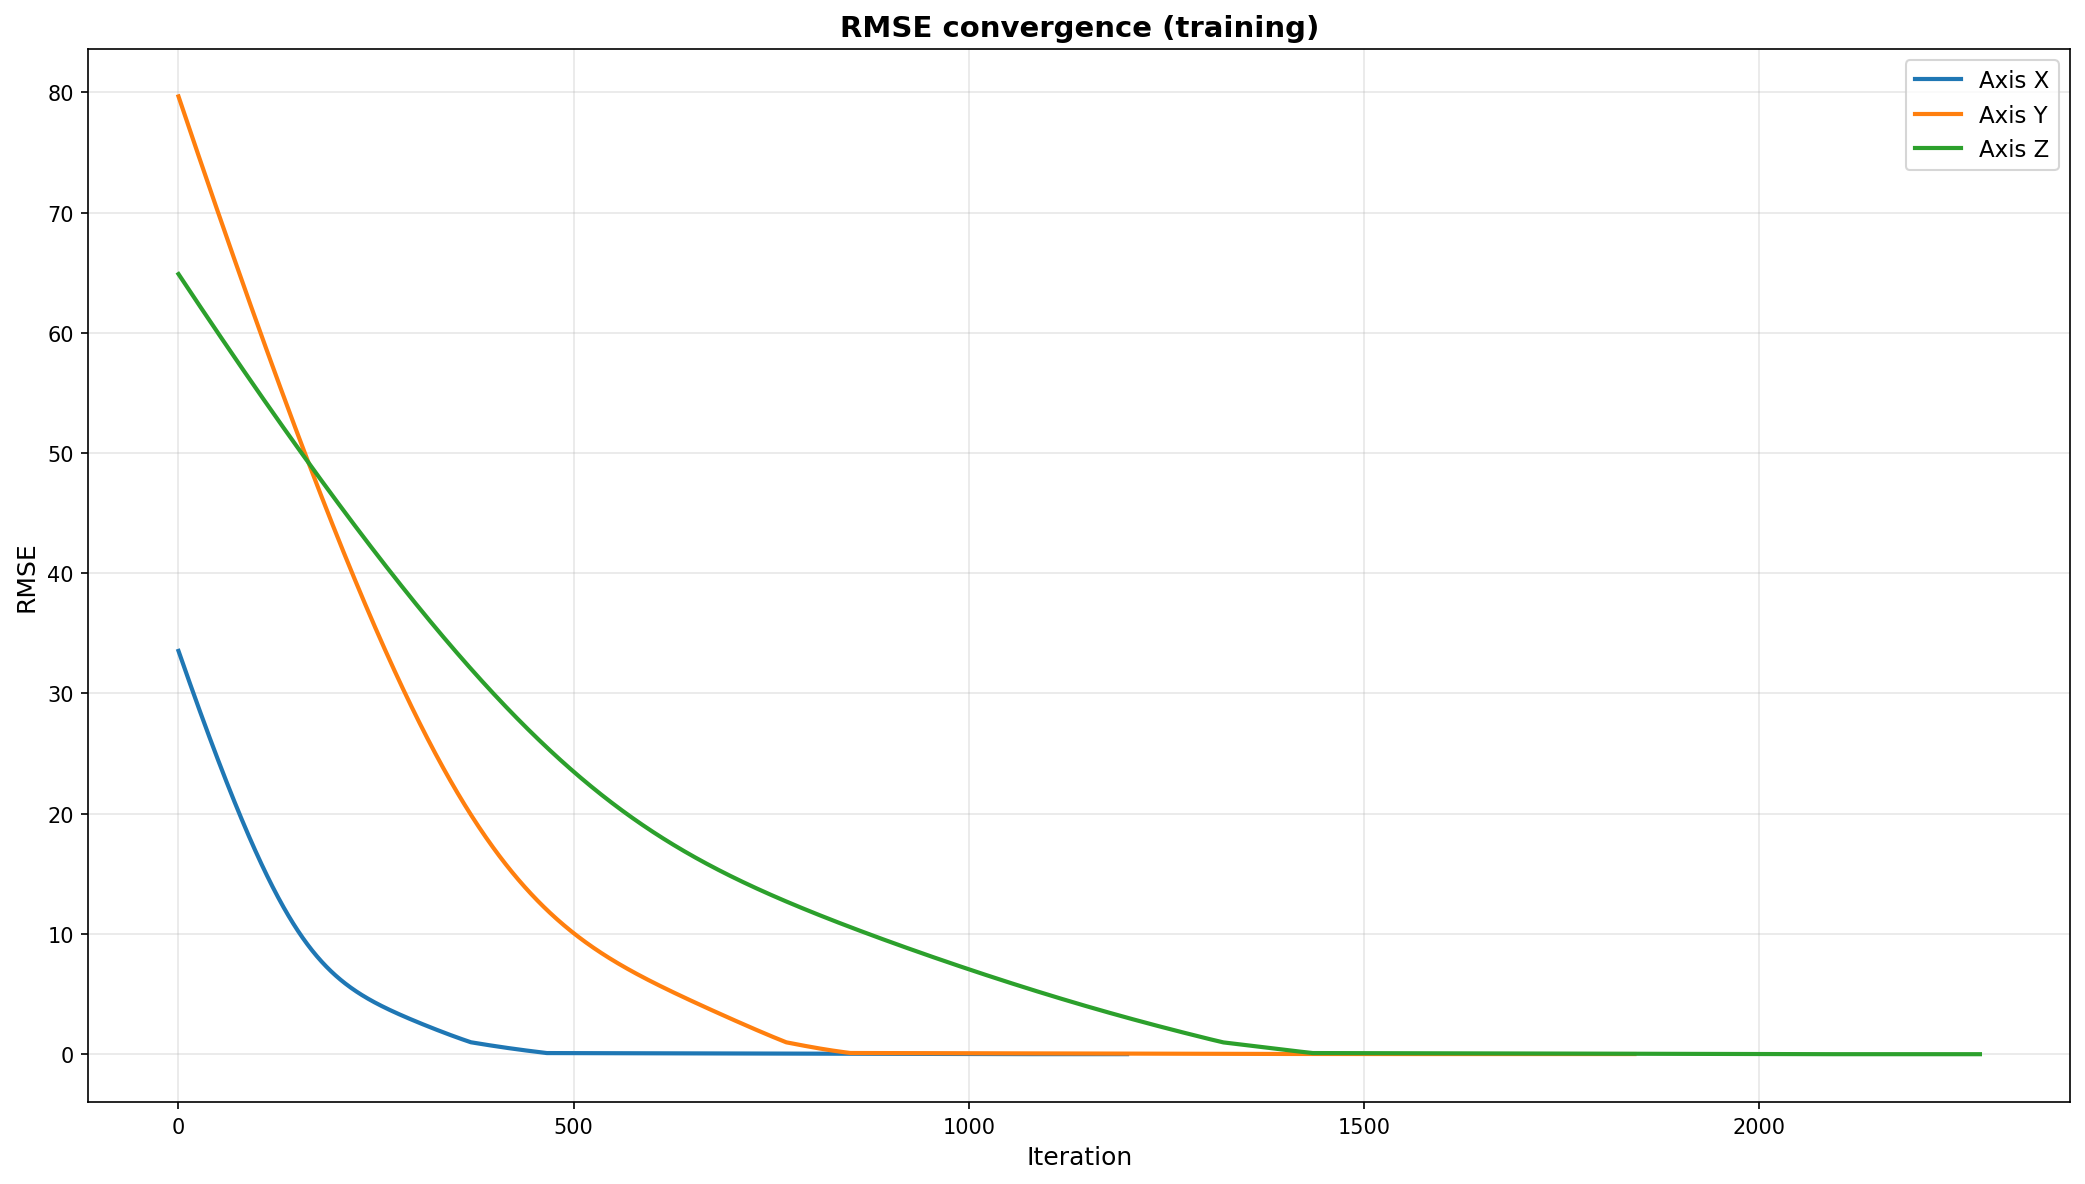

Saved: output_data/02_3d_scatter_predicted_vs_reference.png


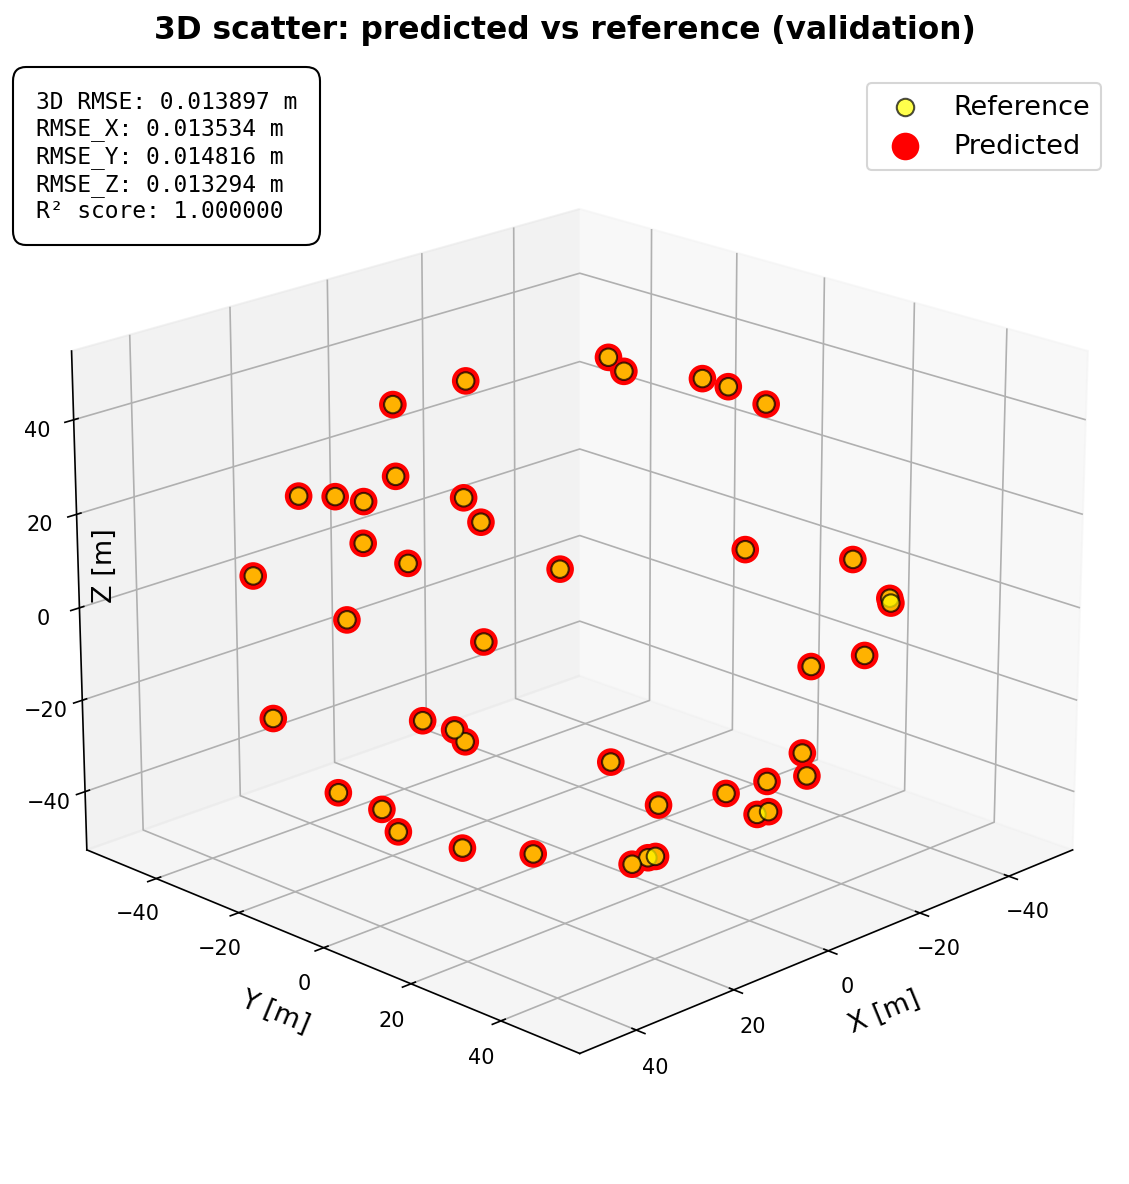

In [12]:

# 1) RMSE convergence (per axis)
plt.figure(figsize=(14, 8), dpi=150)
for k, hist in enumerate(rmse_histories):
    plt.plot(np.arange(len(hist)), hist, label=f"Axis {['X','Y','Z'][k]}", linewidth=2)
plt.title("RMSE convergence (training)", fontsize=14, fontweight='bold')
plt.xlabel("Iteration", fontsize=12)
plt.ylabel("RMSE", fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("output_data/01_rmse_convergence.png", dpi=300, bbox_inches='tight')
print("Saved: output_data/01_rmse_convergence.png")
plt.show()

   
# 2) 3D scatter
if PLOT_3D and len(Xv_local):
    from mpl_toolkits.mplot3d import Axes3D  
    fig = plt.figure(figsize=(18, 8), dpi=150)
    ax = fig.add_subplot(111, projection='3d')


    # Compute metrics
    rmse_3d = np.sqrt(np.mean((Yv_pred - Yv_fixed)**2))
    rmse_per_axis = np.sqrt(np.mean((Yv_pred - Yv_fixed)**2, axis=0))
    r2 = r2_score(Yv_fixed.flatten(), Yv_pred.flatten())

    ax.scatter(Yv_fixed[:,0], Yv_fixed[:,1], Yv_fixed[:,2], marker='o', color="yellow", edgecolors='black', s=70, alpha=0.7, label='Reference')
    ax.scatter(Yv_pred[:,0],  Yv_pred[:,1],  Yv_pred[:,2],  marker='o', color="red", s=150, alpha=1, label='Predicted')
    ax.set_title("3D scatter: predicted vs reference (validation)", fontsize=15, fontweight='bold', pad=15)
    ax.set_xlabel("X"); ax.set_ylabel("Y"); ax.set_zlabel("Z")
    ax.set_xlabel("X [m]", fontsize=13)
    ax.set_ylabel("Y [m]", fontsize=13)
    ax.set_zlabel("")  
    ax.text2D(0.07, 0.55, "Z [m]", transform=ax.transAxes, rotation=90, va="center", ha="left", fontsize=13)
    ax.legend(fontsize=13)
    ax.view_init(elev=20, azim=45)
    ax.tick_params(pad=2)

    metrics_text = (f"3D RMSE: {rmse_3d:.6f} m\n"
                    f"RMSE_X: {rmse_per_axis[0]:.6f} m\n"
                    f"RMSE_Y: {rmse_per_axis[1]:.6f} m\n"
                    f"RMSE_Z: {rmse_per_axis[2]:.6f} m\n"
                    f"R² score: {r2:.6f}")
    
    
    from matplotlib.offsetbox import AnchoredText

    at = AnchoredText(metrics_text, prop=dict(size=11, family='monospace'),
                    frameon=True, loc='upper left')  # loc: 'lower left','upper right', etc.
    at.patch.set_boxstyle("round,pad=0.6")
    ax.add_artist(at)
    
    fig.tight_layout()
    plt.savefig("output_data/02_3d_scatter_predicted_vs_reference.png", dpi=300, bbox_inches='tight')
    print("Saved: output_data/02_3d_scatter_predicted_vs_reference.png")
    plt.show()

## 8. Export Results

In [17]:
# ----------------------------
# 8. Export Results (robust + save transformed datasets) — FIXED for NaN->int
# ----------------------------
import os
import numpy as np
import pandas as pd
os.makedirs("output_data", exist_ok=True)

# Helper: safe scalar conversion
def to_scalar(x, default=np.nan):
    try:
        a = np.asarray(x, dtype=float).ravel()
        if a.size == 0:
            return float(default)
        return float(a[0])
    except Exception:
        try:
            return float(x)
        except Exception:
            return float(default)

# Helper: safe int conversion (returns int(default_on_nan) if NaN)
def to_int_safe(x, default_on_nan=0):
    try:
        v = to_scalar(x, default=np.nan)
        if np.isnan(v):
            return int(default_on_nan)
        return int(v)
    except Exception:
        return int(default_on_nan)

# --- Ensure X_local/X_fixed arrays ---
X_local_a = np.asarray(globals().get("X_local", globals().get("Xtr_local", [])), dtype=float)
X_fixed_a = np.asarray(globals().get("X_fixed", globals().get("Ytr_fixed", [])), dtype=float)

# Safe RMSE extraction (may come from various cells)
rmse_tr_arr = globals().get("rmse_tr", None)
rmse_v_arr = globals().get("rmse_v", None)
if rmse_tr_arr is None and 'df' in globals():
    try:
        rmse_tr_arr = df.loc[0, ["train_rmse_x","train_rmse_y","train_rmse_z"]].to_numpy(dtype=float)
    except Exception:
        rmse_tr_arr = None
if rmse_v_arr is None and 'df' in globals():
    try:
        rmse_v_arr = df.loc[0, ["valid_rmse_x","valid_rmse_y","valid_rmse_z"]].to_numpy(dtype=float)
    except Exception:
        rmse_v_arr = None

# Compose results dict with safe conversions
results = {
    "mode": "GeoPOINT" if globals().get("GEOPOINT_WORKBOOK") else "External",
    "n_total": to_int_safe(globals().get("N", len(X_local_a))),
    "n_gcp": to_int_safe(globals().get("N_GCP", globals().get("n_gcp", np.nan))),
    "n_valid": to_int_safe(globals().get("n_valid", len(X_local_a) - to_int_safe(globals().get("N_GCP", 0)))),
    "R": globals().get("R").tolist() if "R" in globals() else None,
    "t": globals().get("t").tolist() if "t" in globals() else None,
    "orthogonality": {
        "dots": globals().get("dots", {}),
        "norms": globals().get("norms", {}),
        "detR": globals().get("detR", to_scalar(np.nan)),
    },
    "rmse": {
        "training": {
            "sx": to_scalar(rmse_tr_arr[0]) if (rmse_tr_arr is not None and len(rmse_tr_arr)>0) else None,
            "sy": to_scalar(rmse_tr_arr[1]) if (rmse_tr_arr is not None and len(rmse_tr_arr)>1) else None,
            "sz": to_scalar(rmse_tr_arr[2]) if (rmse_tr_arr is not None and len(rmse_tr_arr)>2) else None,
        },
        "validation": {
            "sx": to_scalar(rmse_v_arr[0]) if (rmse_v_arr is not None and len(rmse_v_arr)>0) else None,
            "sy": to_scalar(rmse_v_arr[1]) if (rmse_v_arr is not None and len(rmse_v_arr)>1) else None,
            "sz": to_scalar(rmse_v_arr[2]) if (rmse_v_arr is not None and len(rmse_v_arr)>2) else None,
        },
    },
}

# Rotation-angle metrics (from rep if available)
rep_for_export = globals().get("rep", None)
if rep_for_export is None and "R" in globals():
    try:
        rep_for_export = orthogonality_checks_improved(globals()["R"], return_R_proj=False)
    except Exception:
        rep_for_export = None

angle_deg = None
angle_rad = None
drift_angle_10km = None
drift_col_10km = None
if isinstance(rep_for_export, dict) and 'singular_values' in rep_for_export:
    S = np.asarray(rep_for_export['singular_values'], dtype=float)
    eigs = S**2
    eig_err = float(np.sqrt(np.sum((eigs - 1.0)**2)))
    angle_rad = eig_err
    angle_deg = float(np.degrees(angle_rad))
    drift_angle_10km = float(angle_rad * 10000.0)
    col_norms = np.asarray(rep_for_export.get('col_norms', [1.0,1.0,1.0]), dtype=float)
    col_dev = float(np.max(np.abs(col_norms - 1.0)))
    drift_col_10km = float(col_dev * 10000.0)

results["rotation_metrics"] = {
    "angle_deg": angle_deg,
    "angle_rad": angle_rad,
    "detR": float(rep_for_export.get('detR', np.linalg.det(globals().get("R")))) if rep_for_export is not None else (float(np.linalg.det(globals().get("R"))) if "R" in globals() else None),
    "fro_error": float(rep_for_export.get('fro_error', np.linalg.norm(globals().get("R").T @ globals().get("R") - np.eye(3), ord='fro'))) if ("R" in globals()) else None,
}

# --- Save aggregated results JSON ---
json_path = "output_data/results_past.json"
with open(json_path, "w") as f:
    json.dump(results, f, indent=2)
print(f"Saved: {json_path}")

# --- Save compact CSV summary (single-row) ---
df_out = pd.DataFrame({
    "R11":[globals().get("R")[0,0] if "R" in globals() else None],
    "R12":[globals().get("R")[0,1] if "R" in globals() else None],
    "R13":[globals().get("R")[0,2] if "R" in globals() else None],
    "R21":[globals().get("R")[1,0] if "R" in globals() else None],
    "R22":[globals().get("R")[1,1] if "R" in globals() else None],
    "R23":[globals().get("R")[1,2] if "R" in globals() else None],
    "R31":[globals().get("R")[2,0] if "R" in globals() else None],
    "R32":[globals().get("R")[2,1] if "R" in globals() else None],
    "R33":[globals().get("R")[2,2] if "R" in globals() else None],
    "tX":[globals().get("t")[0] if "t" in globals() else None],
    "tY":[globals().get("t")[1] if "t" in globals() else None],
    "tZ":[globals().get("t")[2] if "t" in globals() else None],
    "detR":[results["rotation_metrics"]["detR"]],
    "rotation_angle_deg":[results["rotation_metrics"]["angle_deg"]],
    "train_sx":[results["rmse"]["training"]["sx"]],
    "train_sy":[results["rmse"]["training"]["sy"]],
    "train_sz":[results["rmse"]["training"]["sz"]],
    "valid_sx":[results["rmse"]["validation"]["sx"]],
    "valid_sy":[results["rmse"]["validation"]["sy"]],
    "valid_sz":[results["rmse"]["validation"]["sz"]],
    "mode":[results["mode"]],
    "n_total":[results["n_total"]],"n_gcp":[results["n_gcp"]],"n_valid":[results["n_valid"]]
})
csv_path = "output_data/results_past.csv"
df_out.to_csv(csv_path, index=False)
print(f"Saved: {csv_path}")

# --- Save per-point transformed datasets ---
def save_transformed_csv(prefix, A, tvec, X_in, Y_ref=None):
    try:
        X_in_a = np.asarray(X_in, dtype=float)
        Y_pred_all = (np.asarray(A, float) @ X_in_a.T + np.asarray(tvec, float).reshape(3,1)).T
        df = pd.DataFrame({
            "X_src": X_in_a[:,0], "Y_src": X_in_a[:,1], "Z_src": X_in_a[:,2],
            "X_pred": Y_pred_all[:,0], "Y_pred": Y_pred_all[:,1], "Z_pred": Y_pred_all[:,2],
        })
        if Y_ref is not None and len(Y_ref)==len(X_in):
            Y_ref_a = np.asarray(Y_ref, dtype=float)
            df["X_ref"] = Y_ref_a[:,0]; df["Y_ref"] = Y_ref_a[:,1]; df["Z_ref"] = Y_ref_a[:,2]
        out_path = f"output_data/{prefix}_transformed.csv"
        df.to_csv(out_path, index=False)
        print(f"Saved: {out_path}")
    except Exception as ex:
        print(f"Skipping {prefix} export (error): {ex}")

# Always try to save PAST_raw if R and t present
if "R" in globals() and "t" in globals() and X_local_a.size > 0:
    save_transformed_csv("PAST_raw", globals()["R"], globals()["t"], X_local_a, X_fixed_a if X_fixed_a.size>0 else None)

# PAST_SVD: project R matrix to orthogonal form if function exists
if 'project_A_to_similarity' in globals() and "R" in globals():
    try:
        A_svd, t_svd, s_svd, R_svd, Svals = project_A_to_similarity(np.asarray(globals()["R"], dtype=float), globals().get("Xtr_local", X_local_a), globals().get("Ytr_fixed", X_fixed_a))
        save_transformed_csv("PAST_SVD", A_svd, t_svd, X_local_a, X_fixed_a if X_fixed_a.size>0 else None)
    except Exception as ex:
        print(f"PAST_SVD export skipped: {ex}")

# LSM_rigid (Kabsch): try to compute if not already available from Appendix 2
if 'A_lsm_rigid' not in globals() or 't_lsm_rigid' not in globals():
    try:
        print("  → Computing LSM_rigid (Kabsch) now...")
        mx = Xtr_local.mean(axis=0)
        my = Ytr_fixed.mean(axis=0)
        Xc = Xtr_local - mx
        Yc = Ytr_fixed - my
        H = Xc.T @ Yc
        U, S, Vt = np.linalg.svd(H)
        R_rigid = Vt.T @ U.T
        if np.linalg.det(R_rigid) < 0:
            Vt[-1, :] *= -1
            R_rigid = Vt.T @ U.T
        t_rigid = my - R_rigid @ mx
        globals()["A_lsm_rigid"] = R_rigid
        globals()["t_lsm_rigid"] = t_rigid
    except Exception as ex:
        print(f"  LSM_rigid computation failed: {ex}")

if 'A_lsm_rigid' in globals() and 't_lsm_rigid' in globals() and X_local_a.size > 0:
    save_transformed_csv("LSM_rigid", globals()["A_lsm_rigid"], globals()["t_lsm_rigid"], X_local_a, X_fixed_a if X_fixed_a.size>0 else None)

# LSM_sim (Umeyama): try to compute if not already available from Appendix 2
if 'A_lsm_sim' not in globals() or 't_lsm_sim' not in globals():
    try:
        print("  → Computing LSM_sim (Umeyama) now...")
        mx = Xtr_local.mean(axis=0)
        my = Ytr_fixed.mean(axis=0)
        Xc = Xtr_local - mx
        Yc = Ytr_fixed - my
        cov = (Xc.T @ Yc) / Xtr_local.shape[0]
        var_x = np.mean(np.sum(Xc ** 2, axis=1))
        U, D, Vt = np.linalg.svd(cov)
        R_sim = Vt.T @ U.T
        if np.linalg.det(R_sim) < 0:
            Vt[-1, :] *= -1
            R_sim = Vt.T @ U.T
            D[-1] *= -1
        s_sim = float(np.sum(D) / var_x) if var_x != 0 else 1.0
        A_sim = s_sim * R_sim
        t_sim = my - A_sim @ mx
        globals()["A_lsm_sim"] = A_sim
        globals()["t_lsm_sim"] = t_sim
    except Exception as ex:
        print(f"  LSM_sim computation failed: {ex}")

if 'A_lsm_sim' in globals() and 't_lsm_sim' in globals() and X_local_a.size > 0:
    save_transformed_csv("LSM_sim", globals()["A_lsm_sim"], globals()["t_lsm_sim"], X_local_a, X_fixed_a if X_fixed_a.size>0 else None)

# HYB (LSM_rigid + learned residuals): try to compute if not already available from Appendix 2
if 'A_res' not in globals() or 't_res' not in globals():
    try:
        print("  → Computing HYB (LSM_rigid + residual correction) now...")
        if 'A_lsm_rigid' in globals() and 't_lsm_rigid' in globals():
            Ytr_base = (globals()["A_lsm_rigid"] @ Xtr_local.T + globals()["t_lsm_rigid"].reshape(3,1)).T
            Etr = Ytr_fixed - Ytr_base
            A_res_temp, t_res_temp, _ = learn_transformation(Xtr_local, Etr, use_torch=TORCH_AVAILABLE, verbose=False, activation=RESIDUAL_ACTIVATION)
            globals()["A_res"] = A_res_temp
            globals()["t_res"] = t_res_temp
    except Exception as ex:
        print(f"  HYB computation failed: {ex}")

if 'A_res' in globals() and 't_res' in globals() and 'A_lsm_rigid' in globals() and X_local_a.size > 0:
    try:
        base_all = (globals()["A_lsm_rigid"] @ X_local_a.T + globals()["t_lsm_rigid"].reshape(3,1)).T
        corr_all = (globals()["A_res"] @ X_local_a.T + globals()["t_res"].reshape(3,1)).T
        Y_hyb_all = base_all + corr_all
        df = pd.DataFrame({
            "X_src": X_local_a[:,0], "Y_src": X_local_a[:,1], "Z_src": X_local_a[:,2],
            "X_pred": Y_hyb_all[:,0], "Y_pred": Y_hyb_all[:,1], "Z_pred": Y_hyb_all[:,2],
        })
        if X_fixed_a.size>0:
            df["X_ref"] = X_fixed_a[:,0]; df["Y_ref"] = X_fixed_a[:,1]; df["Z_ref"] = X_fixed_a[:,2]
        out_path = "output_data/HYB_transformed.csv"
        df.to_csv(out_path, index=False)
        print(f"Saved: {out_path}")
    except Exception as ex:
        print(f"HYB export skipped: {ex}")

print("\nExport complete. Generated files:")
import glob
files = sorted(glob.glob("output_data/*.csv")) + sorted(glob.glob("output_data/*.json"))
for f in files:
    print(f"  ✓ {f}")

Saved: output_data/results_past.json
Saved: output_data/results_past.csv
Saved: output_data/PAST_raw_transformed.csv
Saved: output_data/PAST_SVD_transformed.csv
Saved: output_data/LSM_rigid_transformed.csv
Saved: output_data/LSM_sim_transformed.csv
Saved: output_data/HYB_transformed.csv

Export complete. Generated files:
  ✓ output_data/HYB_transformed.csv
  ✓ output_data/LSM_rigid_transformed.csv
  ✓ output_data/LSM_sim_transformed.csv
  ✓ output_data/PAST_SVD_transformed.csv
  ✓ output_data/PAST_raw_transformed.csv
  ✓ output_data/results_past.csv
  ✓ output_data/results_past.json



## 9. Notes

- If **PyTorch** is not available, the notebook automatically switches to a **NumPy-only** gradient descent implementation with identical interface.
- The bias update is **scaled by 1000** to match the convergence behaviour observed in the original prototype.
- For **reproducibility**, set `RANDOM_SEED` and keep `N_GCP` fixed.


---

## Appendix 1. Linear Analogy of Learning

To illustrate the fundamental concept behind the PAST approach, this section presents a simple one-dimensional analogy of the learning process.  
A perceptron is trained to fit a noisy linear dataset generated with Gaussian noise.  
The resulting plot shows both the true linear function and the noisy data points, together with vertical ridgeline plots that visualize the residual distributions for different X positions.  

This example highlights the *white-box* nature of PAST — the same gradient-based learning principle applies, but in three dimensions for coordinate frame alignment.

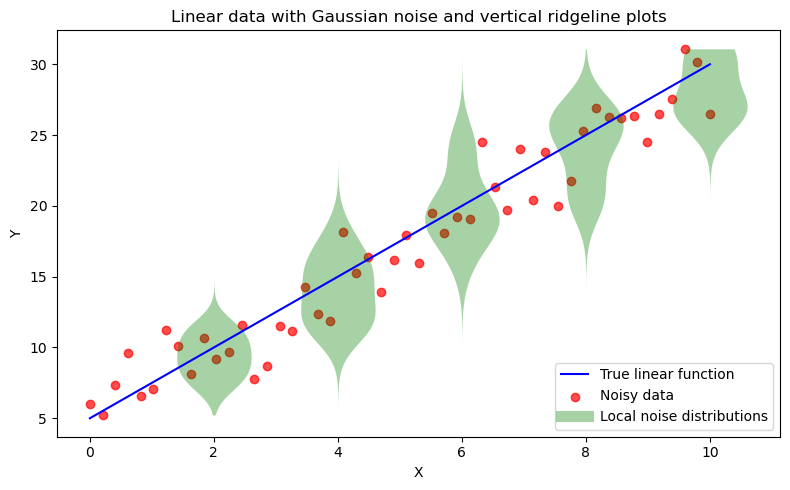

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde

# --- Generate synthetic linear data with Gaussian noise ---
np.random.seed(42)
x = np.linspace(0, 10, 50)
true_y = 2.5 * x + 5
noise = np.random.normal(0, 2, size=x.shape)
y_noisy = true_y + noise

# --- Plot true function and noisy data ---
plt.figure(figsize=(8,5))
line_true, = plt.plot(x, true_y, color='blue', label='True linear function')
scat_noisy = plt.scatter(x, y_noisy, color='red', alpha=0.7, label='Noisy data')

# --- Add vertical ridgeline (violin-like) plots ---
x_bins = np.arange(2, 11, 2)
for xb in x_bins:
    mask = (x >= xb - 1) & (x <= xb + 1)
    if mask.sum() > 3:
        kde = gaussian_kde(y_noisy[mask])
        y_vals = np.linspace(min(y_noisy), max(y_noisy), 200)
        density = kde(y_vals)
        density = density / density.max() * 0.6  # scale horizontally
        plt.fill_betweenx(y_vals, xb - density, xb + density,
                          color='green', alpha=0.35, linewidth=0)

# --- Add dummy patch for legend entry of violin plots ---
violin_patch = plt.Line2D([0], [0], color='green', lw=8, alpha=0.35)
plt.legend(
    handles=[line_true, scat_noisy, violin_patch],
    labels=['True linear function', 'Noisy data', 'Local noise distributions'],
    loc='lower right'
)

plt.title('Linear data with Gaussian noise and vertical ridgeline plots')
plt.xlabel('X')
plt.ylabel('Y')
plt.tight_layout()
plt.show()

**Figure. Linear analogy of the PAST learning process**

The plot illustrates how a perceptron learns a noisy linear relationship — a one-dimensional analogue of the transformation learning performed in PAST.  
The blue line represents the true underlying function, red dots show noisy measurements, and the green ridgeline plots depict the local Gaussian error distributions for different X positions.  
This visualization highlights how gradient-based optimization minimizes deviations toward the ideal model, similar to how PAST aligns 3D coordinate frames under noisy conditions.

## Appendix 2. Consolidated statistics and plots (RMSE / RMST / NRMSE)

This appendix summarises the performance of all transformation variants (PAST, LSM rigid/similarity, and HYB) on training (GCP) and validation data. It reports axis-wise RMSE, RMST (3D aggregate), and range-normalised NRMSE, and visualises the results using grouped bar charts. The appendix also prints scale and determinant checks to validate the geometric consistency of the estimated mappings.

PAST_raw  : singular values(A) = [1.00013575 1.00000536 0.9997861 ]  det(A) = 0.9999271770738708
PAST_SVD  : s = 0.9999757355097829  det(R) = 0.9999999999999992
LSM_rigid : det(R) = 0.9999999999999991
LSM_sim   : s = 0.9999999550840235  det(R) = 1.0000000000000002

--- RMST (≈ RMSE_3D) ---
[PAST_raw]  Train RMST: 0.01311   Valid RMST: 0.02407
[PAST_SVD]  Train RMST: 0.01505   Valid RMST: 0.02349
[LSM_rigid (Kabsch)]  Train RMST: 0.01415   Valid RMST: 0.02440
[LSM_sim (Umeyama)]  Train RMST: 0.01415   Valid RMST: 0.02440
[HYB (LSM_rigid + residual)]  Train RMST: 0.01311   Valid RMST: 0.02390


,method,train_rmse_x,train_rmse_y,train_rmse_z,train_rmst,valid_rmse_x,valid_rmse_y,valid_rmse_z,valid_rmst,NRMSE_tr_x,NRMSE_tr_y,NRMSE_tr_z,NRMSE_tr_3D,NRMSE_v_x,NRMSE_v_y,NRMSE_v_z,NRMSE_v_3D
0,PAST_raw,0.002967,0.012768,0.000405,0.013115,0.013534,0.014816,0.013294,0.024071,0.000042,0.000141,0.000007,0.000102,0.000146,0.000148,0.000142,0.000146
1,PAST_SVD,0.004369,0.013133,0.005904,0.015047,0.014986,0.013611,0.011910,0.023488,0.000062,0.000145,0.000102,0.000117,0.000162,0.000136,0.000127,0.000142
2,LSM_rigid (Kabsch),0.004179,0.013068,0.003451,0.014147,0.017069,0.012513,0.012141,0.024400,0.000060,0.000144,0.000059,0.000110,0.000184,0.000125,0.000130,0.000148
3,LSM_sim (Umeyama),0.004179,0.013068,0.003450,0.014147,0.017069,0.012513,0.012141,0.024400,0.000060,0.000144,0.000059,0.000110,0.000184,0.000125,0.000130,0.000148
4,HYB (LSM_rigid + residual),0.002954,0.012768,0.000401,0.013112,0.013230,0.014803,0.013314,0.023904,0.000042,0.000141,0.000007,0.000102,0.000143,0.000148,0.000142,0.000145


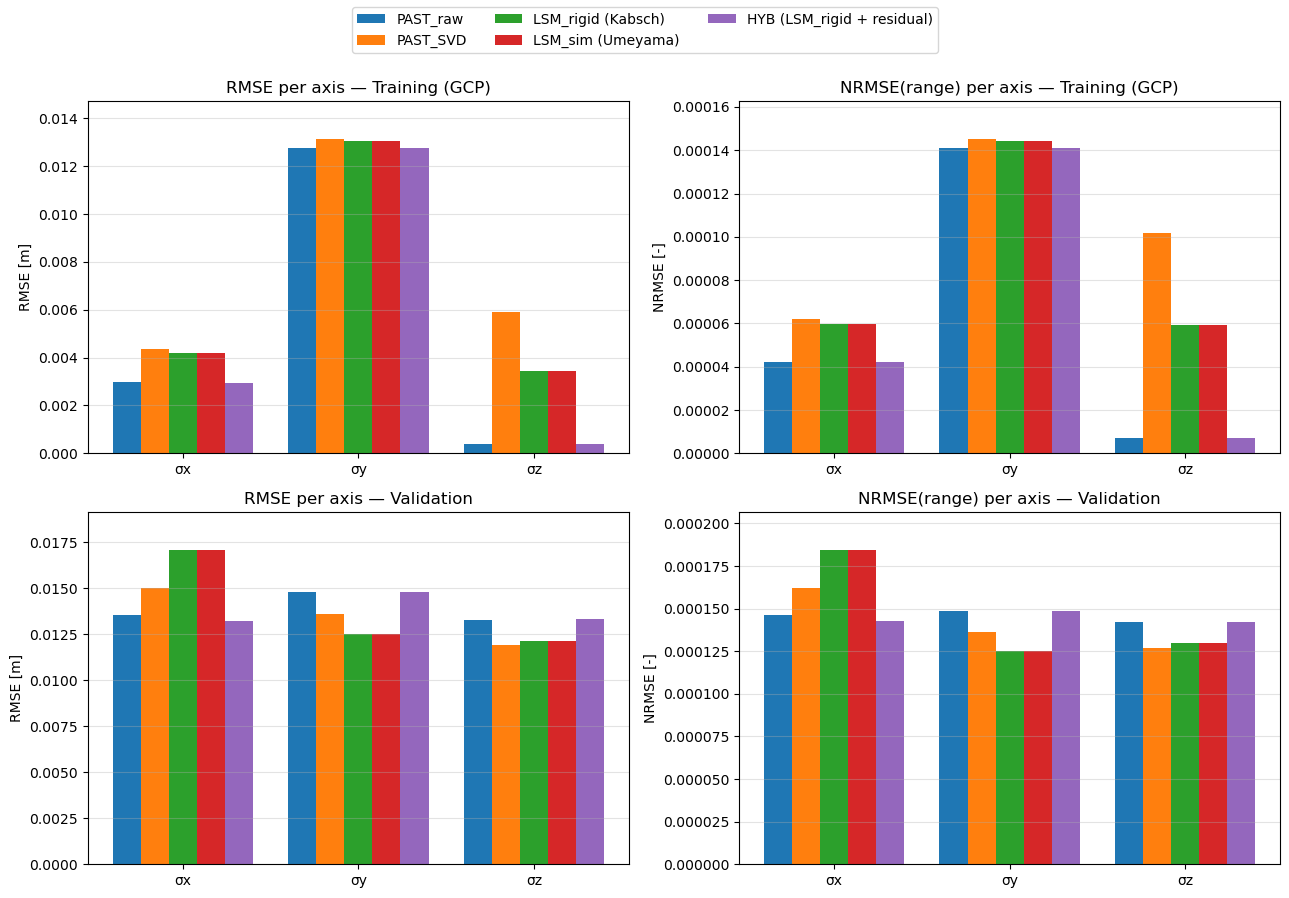


COMPARISON: PAST_raw vs PAST_SVD (3D Residual Error Analysis)

Training (GCP) — Per-point 3D error to reference [m]:
  PAST_raw:  mean=0.011916, median=0.013738, max=0.018664, std=0.005478
  PAST_SVD:  mean=0.014816, median=0.015673, max=0.017212, std=0.002629
  → PAST_SVD improvement (mean): -24.34%

Validation — Per-point 3D error to reference [m]:
  PAST_raw:  mean=0.022507, median=0.023595, max=0.036517, std=0.008535
  PAST_SVD:  mean=0.021821, median=0.023099, max=0.038838, std=0.008690
  → PAST_SVD improvement (mean): 3.05%


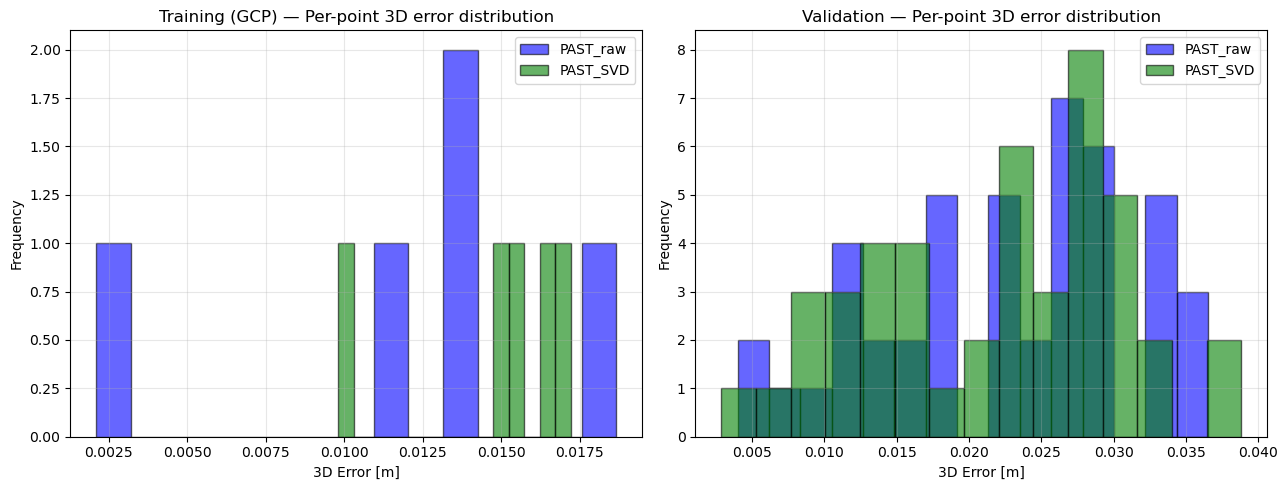

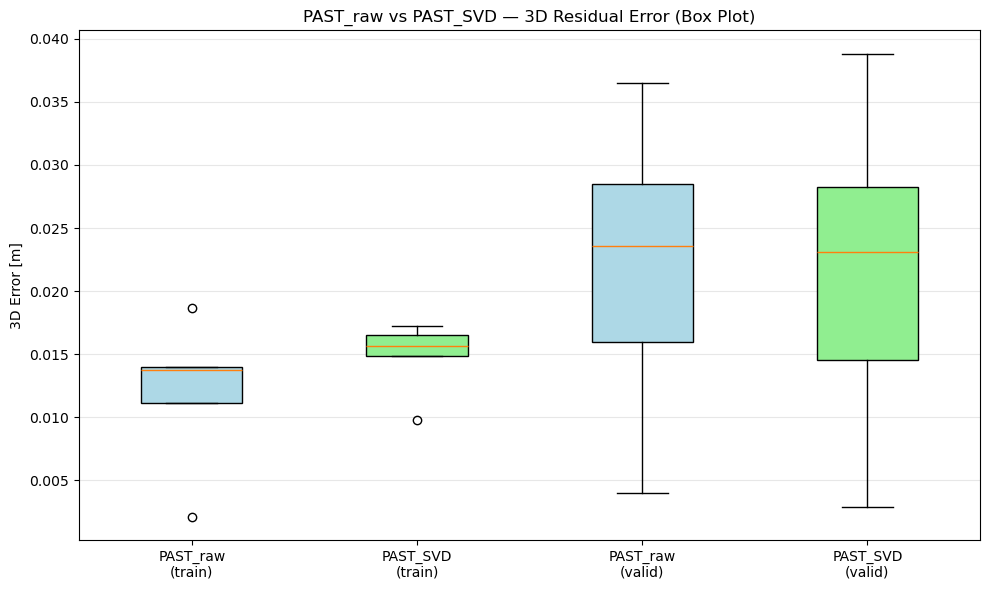

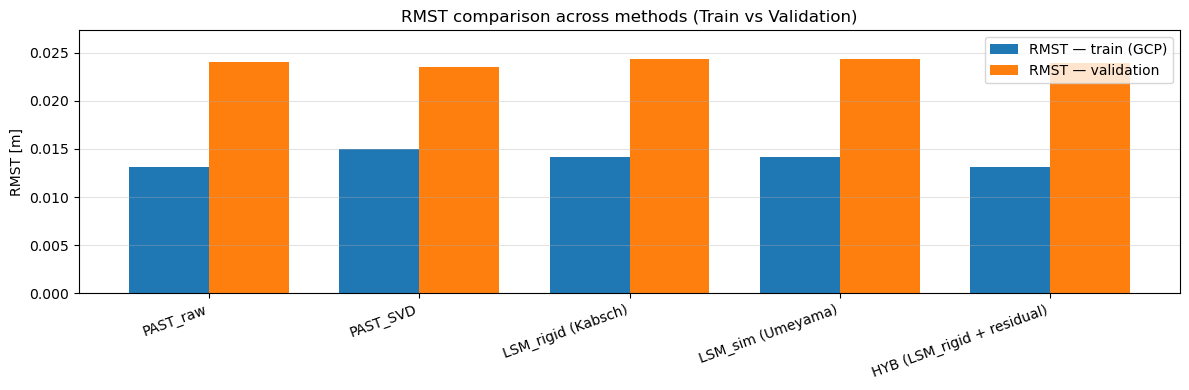

In [19]:
# ============================================================
# APPENDIX 2 — Consolidated statistics and plots (RMSE / RMST / NRMSE)
# ============================================================
# This cell produces a single, reproducible summary of:
#   (1) Parameter sanity checks for each method (determinants, scale factors)
#   (2) A unified metrics table (train/validation):
#       - RMSE per axis (x, y, z)
#       - RMST (3D aggregate from axis-wise RMSE)
#       - NRMSE(range) per axis and NRMSE_3D (range-normalised)
#   (3) Visual comparisons:
#       - 2×2 panel of grouped bars for RMSE and NRMSE (train vs validation)
#       - RMST comparison across methods (train vs validation)
#
# Methods included:
#   - PAST_raw: learned linear mapping (gradient-based)
#   - PAST_SVD: SVD projection of PAST_raw to the closest similarity transform
#   - LSM_rigid (Kabsch): rigid SVD fit (R, t), no scale
#   - LSM_sim (Umeyama): similarity SVD fit (s, R, t), with scale
#   - HYB: LSM_rigid baseline + learned residual correction
#
# Plotting policy:
#   - Linear y-scales are used here.
#   - y-limits are tightened automatically to make small differences visible.
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------
# 0) Sanity checks and inputs
# ----------------------------
for v in ["Xtr_local", "Ytr_fixed", "R", "t"]:
    if v not in globals():
        raise RuntimeError(f"Missing variable '{v}'. Run data split + training first.")

has_valid = ("Xv_local" in globals()) and isinstance(Xv_local, np.ndarray) and (len(Xv_local) > 0)

Xtr = np.asarray(Xtr_local, dtype=float)
Ytr = np.asarray(Ytr_fixed, dtype=float)
Xv  = np.asarray(Xv_local, dtype=float) if has_valid else None
Yv  = np.asarray(Yv_fixed, dtype=float) if has_valid else None

A_past_raw = np.asarray(R, dtype=float)
t_past_raw = np.asarray(t, dtype=float).reshape(3,)

# ----------------------------
# 1) Utility functions
# ----------------------------
def apply_affine(A, t, X):
    """Apply affine mapping: Y = A·X + t."""
    return (np.asarray(A, float) @ np.asarray(X, float).T + np.asarray(t, float).reshape(3, 1)).T

def axis_rmse(Yp, Y):
    """Axis-wise RMSE for paired 3D point sets; returns [rmse_x, rmse_y, rmse_z]."""
    Yp = np.asarray(Yp, dtype=float)
    Y  = np.asarray(Y,  dtype=float)
    return np.sqrt(np.mean((Yp - Y) ** 2, axis=0))

def rmst(rmse_vec3):
    """RMST: 3D aggregate computed from axis-wise RMSE."""
    v = np.asarray(rmse_vec3, dtype=float).reshape(3,)
    return float(np.sqrt(np.sum(v ** 2)))

def range_vec(Y):
    """Axis-wise range (max-min); zeros are converted to NaN to avoid division by zero."""
    Y = np.asarray(Y, dtype=float)
    r = np.max(Y, axis=0) - np.min(Y, axis=0)
    r[r == 0] = np.nan
    return r

def nrmse_range(rmse_vec3, Y_true):
    """NRMSE using range normalisation: per-axis NRMSE and a 3D aggregate NRMSE_3D."""
    r = range_vec(Y_true)
    n = rmse_vec3 / r
    n3 = rmst(rmse_vec3) / float(np.sqrt(np.nansum(r ** 2)))
    return n, float(n3)

def nice_ylim_from_values(ax, values, pad=0.12):
    """
    Set linear y-limits to [0, vmax*(1+pad)] to improve readability when values are close.
    """
    v = np.asarray(values, dtype=float)
    v = v[np.isfinite(v)]
    if v.size == 0:
        return
    vmax = float(np.max(v))
    if vmax <= 0:
        ax.set_ylim(0.0, 1.0)
    else:
        ax.set_ylim(0.0, vmax * (1.0 + pad))

# ----------------------------
# 2) LSM baseline (rigid): Kabsch algorithm
# ----------------------------
def kabsch_rigid(X_src, Y_dst):
    """
    Rigid alignment (rotation + translation) using SVD (Kabsch):
        Y ≈ R·X + t, with det(R)=+1.
    """
    X = np.asarray(X_src, dtype=float)
    Y = np.asarray(Y_dst, dtype=float)
    mx = X.mean(axis=0)
    my = Y.mean(axis=0)
    Xc = X - mx
    Yc = Y - my
    H = Xc.T @ Yc
    U, S, Vt = np.linalg.svd(H)
    R_ = Vt.T @ U.T
    if np.linalg.det(R_) < 0:
        Vt[-1, :] *= -1
        R_ = Vt.T @ U.T
    t_ = my - R_ @ mx
    return R_, t_

# ----------------------------
# 3) LSM baseline (similarity): Umeyama algorithm
# ----------------------------
def umeyama_similarity(X_src, Y_dst):
    """
    Similarity alignment (scale + rotation + translation) using SVD (Umeyama):
        Y ≈ s·R·X + t.
    Returns A=sR, t, s, and R.
    """
    X = np.asarray(X_src, dtype=float)
    Y = np.asarray(Y_dst, dtype=float)
    mx = X.mean(axis=0)
    my = Y.mean(axis=0)
    Xc = X - mx
    Yc = Y - my

    cov = (Xc.T @ Yc) / X.shape[0]
    var_x = np.mean(np.sum(Xc ** 2, axis=1))

    U, D, Vt = np.linalg.svd(cov)
    R_ = Vt.T @ U.T
    if np.linalg.det(R_) < 0:
        Vt[-1, :] *= -1
        R_ = Vt.T @ U.T
        D[-1] *= -1

    s_ = float(np.sum(D) / var_x) if var_x != 0 else 1.0
    A_ = s_ * R_
    t_ = my - A_ @ mx
    return A_, t_, s_, R_

# ----------------------------
# 4) PAST_SVD: project PAST_raw matrix to closest similarity transform
# ----------------------------
def project_A_to_similarity(A, X_ref_for_t, Y_ref_for_t):
    """
    Project a general 3x3 matrix A to the closest similarity form sR:
      - Compute SVD: A = U·S·V^T
      - Set R = U·V^T (enforce det(R)=+1)
      - Set s = mean(S) (isotropic scale)
      - Re-estimate translation using training centroids
    """
    A = np.asarray(A, dtype=float)
    U, S, Vt = np.linalg.svd(A)
    R_ = U @ Vt
    if np.linalg.det(R_) < 0:
        Vt[-1, :] *= -1
        R_ = U @ Vt
    s_ = float(np.mean(S))
    A_ = s_ * R_
    mx = np.asarray(X_ref_for_t, dtype=float).mean(axis=0)
    my = np.asarray(Y_ref_for_t, dtype=float).mean(axis=0)
    t_ = my - A_ @ mx
    return A_, t_, s_, R_, S

A_past_svd, t_past_svd, s_past_svd, R_past_svd, sv_raw = project_A_to_similarity(A_past_raw, Xtr, Ytr)

# ----------------------------
# 5) Build LSM baselines (both rigid and similarity)
# ----------------------------
R_lsm_rigid, t_lsm_rigid = kabsch_rigid(Xtr, Ytr)
A_lsm_rigid = R_lsm_rigid

A_lsm_sim, t_lsm_sim, s_lsm_sim, R_lsm_sim = umeyama_similarity(Xtr, Ytr)

# ----------------------------
# 6) HYB: rigid baseline + learned residual correction
# ----------------------------
if "learn_transformation" not in globals():
    raise RuntimeError("Missing 'learn_transformation'. Run the learning-engine cell first (Section 4).")

# Residuals with respect to the rigid baseline (train/GCP)
Ytr_base = apply_affine(A_lsm_rigid, t_lsm_rigid, Xtr)
Etr = Ytr - Ytr_base

# Residual model activation (can be configured independently)
res_act = globals().get("RESIDUAL_ACTIVATION", globals().get("ACTIVATION", "identity"))

# Learn residual mapping using the same training points
A_res, t_res, _ = learn_transformation(
    Xtr, Etr,
    use_torch=globals().get("TORCH_AVAILABLE", False),
    verbose=False,
    activation=res_act
)

def predict_hyb(X):
    """HYB prediction: rigid baseline + residual correction."""
    base = apply_affine(A_lsm_rigid, t_lsm_rigid, X)
    corr = apply_affine(A_res, t_res, X)
    return base + corr

# ----------------------------
# 7) Evaluate all methods
# ----------------------------
def eval_method(name, pred_tr, pred_v=None):
    """Compute RMSE/RMST/NRMSE for train and validation splits."""
    rmse_tr = axis_rmse(pred_tr, Ytr)
    rmst_tr = rmst(rmse_tr)
    nrmse_tr, nrmse3_tr = nrmse_range(rmse_tr, Ytr)

    if has_valid and pred_v is not None:
        rmse_v = axis_rmse(pred_v, Yv)
        rmst_v = rmst(rmse_v)
        nrmse_v, nrmse3_v = nrmse_range(rmse_v, Yv)
    else:
        rmse_v = np.array([np.nan, np.nan, np.nan])
        rmst_v = np.nan
        nrmse_v = np.array([np.nan, np.nan, np.nan])
        nrmse3_v = np.nan

    return dict(
        method=name,
        train_rmse_x=rmse_tr[0], train_rmse_y=rmse_tr[1], train_rmse_z=rmse_tr[2], train_rmst=rmst_tr,
        valid_rmse_x=rmse_v[0],  valid_rmse_y=rmse_v[1],  valid_rmse_z=rmse_v[2],  valid_rmst=rmst_v,
        NRMSE_tr_x=nrmse_tr[0],  NRMSE_tr_y=nrmse_tr[1],  NRMSE_tr_z=nrmse_tr[2],  NRMSE_tr_3D=nrmse3_tr,
        NRMSE_v_x=nrmse_v[0],    NRMSE_v_y=nrmse_v[1],    NRMSE_v_z=nrmse_v[2],    NRMSE_v_3D=nrmse3_v,
    )

methods = []

# PAST_raw
Ytr_past_raw = apply_affine(A_past_raw, t_past_raw, Xtr)
Yv_past_raw  = apply_affine(A_past_raw, t_past_raw, Xv) if has_valid else None
methods.append(eval_method("PAST_raw", Ytr_past_raw, Yv_past_raw))

# PAST_SVD
Ytr_past_svd = apply_affine(A_past_svd, t_past_svd, Xtr)
Yv_past_svd  = apply_affine(A_past_svd, t_past_svd, Xv) if has_valid else None
methods.append(eval_method("PAST_SVD", Ytr_past_svd, Yv_past_svd))

# LSM rigid (Kabsch)
Ytr_lsm_rigid = apply_affine(A_lsm_rigid, t_lsm_rigid, Xtr)
Yv_lsm_rigid  = apply_affine(A_lsm_rigid, t_lsm_rigid, Xv) if has_valid else None
methods.append(eval_method("LSM_rigid (Kabsch)", Ytr_lsm_rigid, Yv_lsm_rigid))

# LSM similarity (Umeyama)
Ytr_lsm_sim = apply_affine(A_lsm_sim, t_lsm_sim, Xtr)
Yv_lsm_sim  = apply_affine(A_lsm_sim, t_lsm_sim, Xv) if has_valid else None
methods.append(eval_method("LSM_sim (Umeyama)", Ytr_lsm_sim, Yv_lsm_sim))

# HYB (rigid baseline + residual)
Ytr_hyb = predict_hyb(Xtr)
Yv_hyb  = predict_hyb(Xv) if has_valid else None
methods.append(eval_method("HYB (LSM_rigid + residual)", Ytr_hyb, Yv_hyb))

df = pd.DataFrame(methods)

# ----------------------------
# 8) Parameter sanity output
# ----------------------------
print("PAST_raw  : singular values(A) =", np.asarray(sv_raw, dtype=float), " det(A) =", float(np.linalg.det(A_past_raw)))
print("PAST_SVD  : s =", float(s_past_svd), " det(R) =", float(np.linalg.det(R_past_svd)))
print("LSM_rigid : det(R) =", float(np.linalg.det(R_lsm_rigid)))
print("LSM_sim   : s =", float(s_lsm_sim), " det(R) =", float(np.linalg.det(R_lsm_sim)))

print("\n--- RMST (≈ RMSE_3D) ---")
for _, row in df.iterrows():
    print(f"[{row['method']}]  Train RMST: {row['train_rmst']:.5f}   Valid RMST: {row['valid_rmst']:.5f}")

display(df)

# ----------------------------
# 9) Bar plots (linear scale with tightened y-limits)
# ----------------------------
method_names = df["method"].tolist()
axes_labels = ["σx", "σy", "σz"]

rmse_tr = df[["train_rmse_x", "train_rmse_y", "train_rmse_z"]].to_numpy(dtype=float)
rmse_v  = df[["valid_rmse_x", "valid_rmse_y", "valid_rmse_z"]].to_numpy(dtype=float)

nrmse_tr = df[["NRMSE_tr_x", "NRMSE_tr_y", "NRMSE_tr_z"]].to_numpy(dtype=float)
nrmse_v  = df[["NRMSE_v_x", "NRMSE_v_y", "NRMSE_v_z"]].to_numpy(dtype=float)

def grouped_bar(ax, values, title, ylabel):
    """Grouped bars for (methods × axes)."""
    values = np.asarray(values, dtype=float)  # shape (n_methods, 3)
    M = values.shape[0]
    x = np.arange(3)
    w = 0.80 / max(M, 1)

    for i in range(M):
        ax.bar(x + (i - (M - 1) / 2) * w, values[i, :], width=w, label=method_names[i])

    ax.set_xticks(x)
    ax.set_xticklabels(axes_labels)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(axis="y", alpha=0.35)

    nice_ylim_from_values(ax, values[np.isfinite(values)], pad=0.12)

fig, axs = plt.subplots(2, 2, figsize=(13, 9))

grouped_bar(axs[0, 0], rmse_tr,  "RMSE per axis — Training (GCP)",        "RMSE [m]")
grouped_bar(axs[1, 0], rmse_v,   "RMSE per axis — Validation",            "RMSE [m]")
grouped_bar(axs[0, 1], nrmse_tr, "NRMSE(range) per axis — Training (GCP)", "NRMSE [-]")
grouped_bar(axs[1, 1], nrmse_v,  "NRMSE(range) per axis — Validation",     "NRMSE [-]")

handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=3, frameon=True)

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

# ---
# COMPARISON: PAST_raw vs PAST_SVD (3D residual error analysis)
# ---
# Compute per-point 3D errors (Euclidean distance to reference) for both methods
def compute_3d_error(Y_pred, Y_ref):
    """Compute per-point 3D Euclidean error."""
    Y_pred = np.asarray(Y_pred, dtype=float)
    Y_ref  = np.asarray(Y_ref,  dtype=float)
    if Y_pred.shape != Y_ref.shape or Y_pred.shape[0] == 0:
        return np.array([])
    diff = Y_pred - Y_ref
    return np.sqrt(np.sum(diff**2, axis=1))

# PAST_raw errors (training)
err_raw_tr = compute_3d_error(Ytr_past_raw, Ytr) if has_valid or len(Xtr) > 0 else np.array([])
# PAST_SVD errors (training)
err_svd_tr = compute_3d_error(Ytr_past_svd, Ytr) if has_valid or len(Xtr) > 0 else np.array([])

# PAST_raw errors (validation)
err_raw_v = compute_3d_error(Yv_past_raw, Yv) if (has_valid and len(Xv) > 0) else np.array([])
# PAST_SVD errors (validation)
err_svd_v = compute_3d_error(Yv_past_svd, Yv) if (has_valid and len(Xv) > 0) else np.array([])

print("\n" + "="*85)
print("COMPARISON: PAST_raw vs PAST_SVD (3D Residual Error Analysis)")
print("="*85)

print("\nTraining (GCP) — Per-point 3D error to reference [m]:")
if err_raw_tr.size > 0:
    print(f"  PAST_raw:  mean={np.mean(err_raw_tr):.6f}, median={np.median(err_raw_tr):.6f}, max={np.max(err_raw_tr):.6f}, std={np.std(err_raw_tr):.6f}")
    print(f"  PAST_SVD:  mean={np.mean(err_svd_tr):.6f}, median={np.median(err_svd_tr):.6f}, max={np.max(err_svd_tr):.6f}, std={np.std(err_svd_tr):.6f}")
    improvement_mean = (np.mean(err_raw_tr) - np.mean(err_svd_tr)) / np.mean(err_raw_tr) * 100 if np.mean(err_raw_tr) > 0 else 0
    print(f"  → PAST_SVD improvement (mean): {improvement_mean:.2f}%")
else:
    print("  (No training data to compare)")

print("\nValidation — Per-point 3D error to reference [m]:")
if err_raw_v.size > 0:
    print(f"  PAST_raw:  mean={np.mean(err_raw_v):.6f}, median={np.median(err_raw_v):.6f}, max={np.max(err_raw_v):.6f}, std={np.std(err_raw_v):.6f}")
    print(f"  PAST_SVD:  mean={np.mean(err_svd_v):.6f}, median={np.median(err_svd_v):.6f}, max={np.max(err_svd_v):.6f}, std={np.std(err_svd_v):.6f}")
    improvement_mean = (np.mean(err_raw_v) - np.mean(err_svd_v)) / np.mean(err_raw_v) * 100 if np.mean(err_raw_v) > 0 else 0
    print(f"  → PAST_SVD improvement (mean): {improvement_mean:.2f}%")
else:
    print("  (No validation data to compare)")

# Visualize per-point errors (histograms + box plot)
if err_raw_tr.size > 0 or err_raw_v.size > 0:
    fig, axs = plt.subplots(1, 2, figsize=(13, 5))
    
    # Histogram of training errors
    if err_raw_tr.size > 0:
        axs[0].hist(err_raw_tr, bins=15, alpha=0.6, label="PAST_raw", color="blue", edgecolor="black")
        axs[0].hist(err_svd_tr, bins=15, alpha=0.6, label="PAST_SVD", color="green", edgecolor="black")
        axs[0].set_xlabel("3D Error [m]")
        axs[0].set_ylabel("Frequency")
        axs[0].set_title("Training (GCP) — Per-point 3D error distribution")
        axs[0].legend()
        axs[0].grid(alpha=0.3)
    
    # Histogram of validation errors
    if err_raw_v.size > 0:
        axs[1].hist(err_raw_v, bins=15, alpha=0.6, label="PAST_raw", color="blue", edgecolor="black")
        axs[1].hist(err_svd_v, bins=15, alpha=0.6, label="PAST_SVD", color="green", edgecolor="black")
        axs[1].set_xlabel("3D Error [m]")
        axs[1].set_ylabel("Frequency")
        axs[1].set_title("Validation — Per-point 3D error distribution")
        axs[1].legend()
        axs[1].grid(alpha=0.3)
    else:
        axs[1].text(0.5, 0.5, "No validation data", ha="center", va="center", transform=axs[1].transAxes)
    
    plt.tight_layout()
    plt.show()

# Box plot comparison
if err_raw_tr.size > 0 or err_raw_v.size > 0:
    fig, ax = plt.subplots(figsize=(10, 6))
    data_to_plot = []
    labels_list = []
    
    if err_raw_tr.size > 0:
        data_to_plot.append(err_raw_tr)
        labels_list.append("PAST_raw\n(train)")
        data_to_plot.append(err_svd_tr)
        labels_list.append("PAST_SVD\n(train)")
    
    if err_raw_v.size > 0:
        data_to_plot.append(err_raw_v)
        labels_list.append("PAST_raw\n(valid)")
        data_to_plot.append(err_svd_v)
        labels_list.append("PAST_SVD\n(valid)")
    
    bp = ax.boxplot(data_to_plot, tick_labels=labels_list, patch_artist=True)
    
    # Color: blue for PAST_raw, green for PAST_SVD
    colors = ["lightblue", "lightgreen"] * 2
    for patch, color in zip(bp["boxes"], colors):
        patch.set_facecolor(color)
    
    ax.set_ylabel("3D Error [m]")
    ax.set_title("PAST_raw vs PAST_SVD — 3D Residual Error (Box Plot)")
    ax.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()

print("="*85)

# ----------------------------
# 10) RMST comparison (train vs validation)
# ----------------------------
rmst_tr = df["train_rmst"].to_numpy(dtype=float)
rmst_v  = df["valid_rmst"].to_numpy(dtype=float)

x = np.arange(len(method_names))
w = 0.38

plt.figure(figsize=(12, 4))
plt.bar(x - w / 2, rmst_tr, width=w, label="RMST — train (GCP)")
plt.bar(x + w / 2, rmst_v,  width=w, label="RMST — validation")

plt.xticks(x, method_names, rotation=20, ha="right")
plt.ylabel("RMST [m]")
plt.title("RMST comparison across methods (Train vs Validation)")
plt.grid(axis="y", alpha=0.35)

# Ensure the y-axis shows small differences clearly on a linear scale
nice_ylim_from_values(plt.gca(), np.r_[rmst_tr, rmst_v], pad=0.12)

plt.legend()
plt.tight_layout()
plt.show()
